In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
!wget http://s3.amazonaws.com/open.source.geoscience/open_data/newzealand/Taranaiki_Basin/PARIHAKA-3D/Parihaka_PSTM_mid_stack.sgy

--2019-12-14 21:55:23--  http://s3.amazonaws.com/open.source.geoscience/open_data/newzealand/Taranaiki_Basin/PARIHAKA-3D/Parihaka_PSTM_mid_stack.sgy
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.98.125
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.98.125|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5099504464 (4.7G) [application/octet-stream]
Saving to: ‘Parihaka_PSTM_mid_stack.sgy’

Parihaka_PSTM_mid_s 100%[===================>]   4.75G  48.6MB/s    in 1m 41s  

2019-12-14 21:57:04 (48.1 MB/s) - ‘Parihaka_PSTM_mid_stack.sgy’ saved [5099504464/5099504464]



In [4]:
!pip install segyio

     |████████████████████████████████| 92kB 4.2MB/s 


In [0]:
import segyio

In [0]:
import os, sys
import numpy as np, pandas as pd
import numpy as np, pandas as pd
import segyio
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# data = segyio.tools.cube(path_raw)
data = segyio.tools.cube("Parihaka_PSTM_mid_stack.sgy")
sample = np.fromfile("gxl.dat", dtype=np.single).reshape(512,384,128)

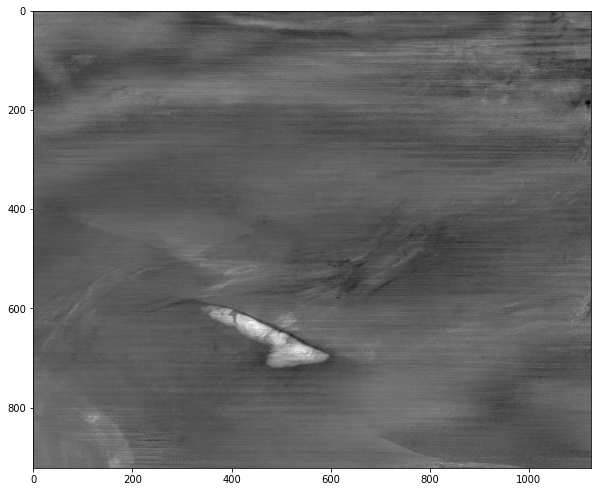

In [0]:
plt.figure(figsize=(10, 10))
plt.imshow(data[:, :, 100], cmap='gray')

In [0]:
# data.shape

In [0]:
downloaded = drive.CreateFile({'id': "1AL0uRqBa0umRc-xHTOuviCc4XWbxWj1j"})
downloaded.GetContentFile('model.hdf5')

In [0]:
downloaded = drive.CreateFile({"id": "1mAYnIlvjBFtogeHyNF9Tc7PHwWGvrifd"})
downloaded.GetContentFile("model.json")

In [0]:
downloaded = drive.CreateFile({"id": "1s6JDp2LEgO8dtBCOEoQdTY39ch2icGtU"})
downloaded.GetContentFile("gxl.dat")

In [0]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(pretrained_weights = None,input_size = (128,128,128,1)):
    inputs = Input(input_size)
    conv1 = Conv3D(16, (3,3,3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(16, (3,3,3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(2,2,2))(conv1)

    conv2 = Conv3D(32, (3,3,3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(32, (3,3,3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(2,2,2))(conv2)

    conv3 = Conv3D(64, (3,3,3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(64, (3,3,3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(2,2,2))(conv3)

    conv4 = Conv3D(512, (3,3,3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(512, (3,3,3), activation='relu', padding='same')(conv4)

    up5 = concatenate([UpSampling3D(size=(2,2,2))(conv4), conv3], axis=4)
    conv5 = Conv3D(64, (3,3,3), activation='relu', padding='same')(up5)
    conv5 = Conv3D(64, (3,3,3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling3D(size=(2,2,2))(conv5), conv2], axis=4)
    conv6 = Conv3D(32, (3,3,3), activation='relu', padding='same')(up6)
    conv6 = Conv3D(32, (3,3,3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling3D(size=(2,2,2))(conv6), conv1], axis=4)
    conv7 = Conv3D(16, (3,3,3), activation='relu', padding='same')(up7)
    conv7 = Conv3D(16, (3,3,3), activation='relu', padding='same')(conv7)

    conv8 = Conv3D(1, (1,1,1), activation='sigmoid')(conv7)

    model = Model(inputs=[inputs], outputs=[conv8])
    model.compile(optimizer = Adam(lr = 1e-4), loss = cross_entropy_balanced, metrics = ['accuracy'])
  
    return model
def cross_entropy_balanced(y_true, y_pred):
    # Note: tf.nn.sigmoid_cross_entropy_with_logits expects y_pred is logits, 
    # Keras expects probabilities.
    # transform y_pred back to logits
    _epsilon = _to_tensor(K.epsilon(), y_pred.dtype.base_dtype)
    y_pred   = tf.clip_by_value(y_pred, _epsilon, 1 - _epsilon)
    y_pred   = tf.log(y_pred/ (1 - y_pred))

    y_true = tf.cast(y_true, tf.float32)

    count_neg = tf.reduce_sum(1. - y_true)
    count_pos = tf.reduce_sum(y_true)

    beta = count_neg / (count_neg + count_pos)

    pos_weight = beta / (1 - beta)

    cost = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, targets=y_true, pos_weight=pos_weight)

    cost = tf.reduce_mean(cost * (1 - beta))

    return tf.where(tf.equal(count_pos, 0.0), 0.0, cost)


def _to_tensor(x, dtype):
    """Convert the input `x` to a tensor of type `dtype`.
    # Arguments
    x: An object to be converted (numpy array, list, tensors).
    dtype: The destination type.
    # Returns
    A tensor.
    """
    x = tf.convert_to_tensor(x)
    if x.dtype != dtype:
        x = tf.cast(x, dtype)
    return x


def getMask(os):
    sc = np.zeros((n1,n2,n3),dtype=np.single)
    sc = sc+1
    sp = np.zeros((os),dtype=np.single)
    sig = os/4
    sig = 0.5/(sig*sig)
    for ks in range(os):
        ds = ks-os+1
        sp[ks] = np.exp(-ds*ds*sig)
    for k1 in range(os):
        for k2 in range(n2):
            for k3 in range(n3):
                sc[k1][k2][k3]=sp[k1]
                sc[n1-k1-1][k2][k3]=sp[k1]
    for k1 in range(n1):
        for k2 in range(os):
            for k3 in range(n3):
                sc[k1][k2][k3]=sp[k2]
                sc[k1][n3-k2-1][k3]=sp[k2]
    for k1 in range(n1):
        for k2 in range(n2):
            for k3 in range(os):
                sc[k1][k2][k3]=sp[k3]
                sc[k1][k2][n3-k3-1]=sp[k3]
    return sc

Using TensorFlow backend.


In [0]:
from keras.models import load_model

In [0]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

# loaded_model_json = str(SIZE).join([loaded_model_json[:152], loaded_model_json[155:]])
# loaded_model_json = str(SIZE).join([loaded_model_json[:157], loaded_model_json[160:]])
# loaded_model_json = str(SIZE).join([loaded_model_json[:162], loaded_model_json[165:]])

In [0]:
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.hdf5")
print("Loaded model from disk")

# training image dimensions
# n1, n2, n3 = 128, 128, 128









Loaded model from disk


In [0]:
# data = segyio.tools.cube("Parihaka_PSTM_mid_stack.sgy")
# data = data - np.min(data)
# data = data / np.max(data)
# data = data * 255

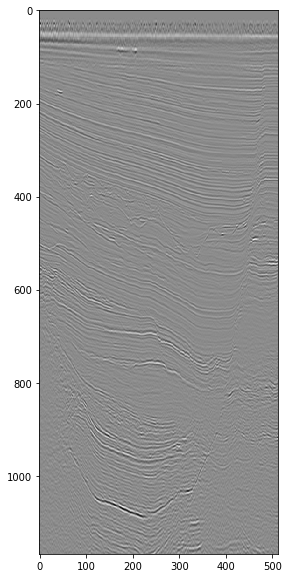

In [0]:
plt.figure(figsize=(10, 10))
plt.imshow(data[:512].T[:, 256], cmap="gray")

In [0]:
def interpolation(inp):
 return (inp[::2, ::2, ::2] + inp[1::2, ::2, ::2] + inp[::2, 1::2, ::2] + inp[::2, ::2, 1::2] +
         inp[1::2, 1::2, ::2] + inp[1::2, ::2, 1::2] + inp[::2, 1::2, 1::2] + inp[1::2, 1::2, 1::2])  / 8

In [0]:
SIZE = 256
X = interpolation(data[:SIZE, :SIZE, :SIZE]).reshape(1, SIZE // 2, SIZE // 2, SIZE // 2, 1)
predicted = loaded_model.predict(X, verbose=1)

1/1 [==============================] - 0s 257ms/step


In [0]:
predicted.shape

(1, 256, 256, 256, 1)

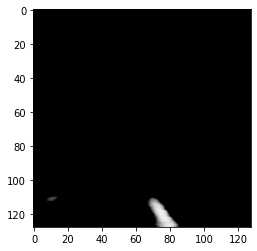

In [0]:
# plt.imshow(predicted[0, 50,..., 0].T, cmap="gray")
plt.imshow(np.transpose(predicted[0, 29,..., 0]), interpolation="bilinear", vmin=0.4, vmax=1.0, cmap=plt.cm.gray)

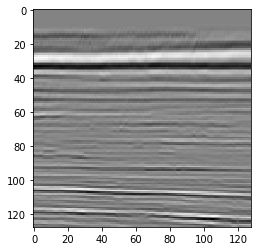

In [0]:
plt.imshow(X[0, 29, ..., 0].T, cmap="gray")

In [0]:
sample = np.fromfile("gxl.dat", dtype=np.single).reshape(512,384,128)

In [0]:
SIZE = 128
s_x = sample[:SIZE, :SIZE, :SIZE].reshape(1, SIZE, SIZE, SIZE, 1)
s_predicted = loaded_model.predict(s_x, verbose=1)

1/1 [==============================] - 0s 138ms/step


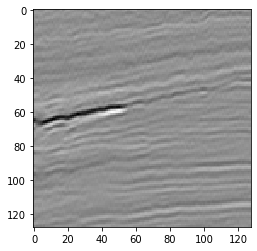

In [0]:
plt.imshow(np.transpose(s_x[0, 29, ..., 0]), cmap="gray")

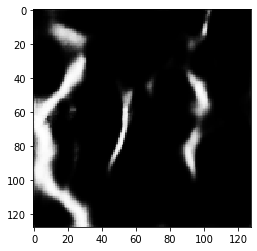

In [0]:
plt.imshow(np.transpose(s_predicted[0, 29, ..., 0]), cmap="gray")

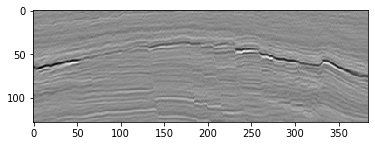

In [0]:
plt.imshow(np.transpose(sample[29]), cmap="gray")

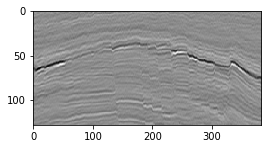

In [0]:
fig = plt.figure(figsize=(9,9))
p1 = plt.subplot(1, 2, 1)
p1.imshow(np.transpose(sample[29]),aspect=1.5,cmap=plt.cm.gray)

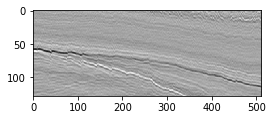

In [0]:
fig = plt.figure(figsize=(9,9))
p1 = plt.subplot(1, 2, 1)
p1.imshow(np.transpose(sample[:, 29]),aspect=1.5,cmap=plt.cm.gray)

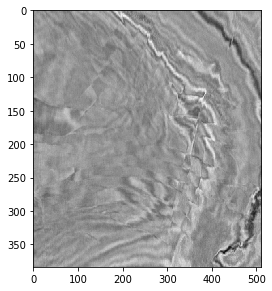

In [0]:
fig = plt.figure(figsize=(9,9))
p1 = plt.subplot(1, 2, 1)
p1.imshow(np.transpose(sample[:, :, 99]),aspect=1.5,cmap=plt.cm.gray)

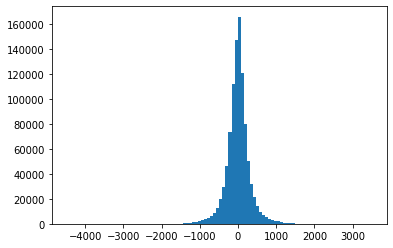

In [0]:
plt.hist(flatten_data[:1000000], bins=100)
plt.show()

In [0]:
np.percentile(flatten_data, [0.0001, 99.999])

array([-4542.99661059,  3581.22005846])

In [0]:
data.max(), data.min()

(3.4028235e+38, -3.4028235e+38)

In [0]:
data = segyio.tools.cube("Parihaka_PSTM_mid_stack.sgy")
# data = data - np.min(data)
# data = data / np.max(data)
# data = data * 255

In [0]:
flatten_data = data.flatten()

In [0]:
sample.min(), sample.max()

(-32767.0, 29793.0)

In [0]:
flatten_sample = sample.flatten()

In [0]:
# flatten_sample.shape
25165824

(25165824,)

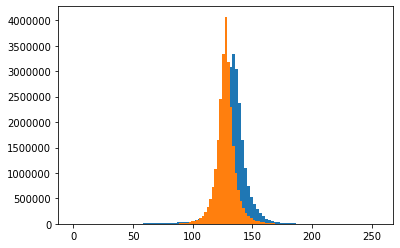

In [0]:
plt.hist(flatten_sample, bins=100)
plt.hist(flatten_data[:25165824], bins=100)
plt.show()

In [0]:
data = np.clip(data, -5000, 5000)

In [0]:
data = data - np.min(data)
data = data / np.max(data)
data = data * 255

In [0]:
sample = sample - np.min(sample)
sample = sample / np.max(sample)
sample = sample * 255

In [0]:
data *= sample.std() / data.std()
data -= data.mean() - sample.mean()

In [24]:
sample.mean(), sample.std()

(133.57925, 12.0905485)

In [25]:
data.mean(), data.std()

(133.35313, 12.090512)

In [0]:
# data = interpolation(data)
# data = data.T
# data = data.T

In [0]:
# data = np.transpose(data, (1, 0, 2))
data = data.T
data = np.transpose(data, (1, 0, 2))

In [0]:
m1, m2, m3 = data.shape
n1, n2, n3 = 128, 128, 128
qq = 0

os = 12 #overlap width
c1 = np.round((m1+os)/(n1-os)+0.5)
c2 = np.round((m2+os)/(n2-os)+0.5)
c3 = np.round((m3+os)/(n3-os)+0.5)
c1 = int(c1)
c2 = int(c2)
c3 = int(c3)
p1 = (n1-os)*c1+os
p2 = (n2-os)*c2+os
p3 = (n3-os)*c3+os
# gx = np.reshape(gx,(m1,m2,m3))
gp = np.zeros((p1,p2,p3),dtype=np.single)
gy = np.zeros((p1,p2,p3),dtype=np.single)
mk = np.zeros((p1,p2,p3),dtype=np.single)
gs = np.zeros((1,n1,n2,n3,1),dtype=np.single)
gp[0:m1,0:m2,0:m3]=data
sc = getMask(os)
for k1 in range(c1):
    for k2 in tqdm(range(c2)):
        for k3 in range(c3):
            b1 = k1*n1-k1*os
            e1 = b1+n1
            b2 = k2*n2-k2*os
            e2 = b2+n2
            b3 = k3*n3-k3*os
            e3 = b3+n3
            gs[0,:,:,:,0]=gp[b1:e1,b2:e2,b3:e3]
            # gs = gs-np.min(gs)
            # gs = gs/np.max(gs)
            # gs = gs*255
            Y = loaded_model.predict(gs, verbose=1)
            Y = np.array(Y)
            gy[b1:e1,b2:e2,b3:e3]= gy[b1:e1,b2:e2,b3:e3]+Y[0,:,:,:,0]*sc
            mk[b1:e1,b2:e2,b3:e3]= mk[b1:e1,b2:e2,b3:e3]+sc
            
gy = gy/mk
gy = gy[0:m1,0:m2,0:m3]

  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 123ms/step


 20%|██        | 1/5 [00:00<00:03,  1.17it/s]

1/1 [==============================] - 0s 123ms/step


 40%|████      | 2/5 [00:01<00:02,  1.17it/s]

1/1 [==============================] - 0s 123ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.17it/s]

1/1 [==============================] - 0s 124ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.18it/s]

1/1 [==============================] - 0s 124ms/step


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 123ms/step


 20%|██        | 1/5 [00:00<00:03,  1.18it/s]

1/1 [==============================] - 0s 123ms/step


 40%|████      | 2/5 [00:01<00:02,  1.18it/s]

1/1 [==============================] - 0s 123ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.18it/s]

1/1 [==============================] - 0s 123ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.18it/s]

1/1 [==============================] - 0s 124ms/step


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 123ms/step


 20%|██        | 1/5 [00:00<00:03,  1.17it/s]

1/1 [==============================] - 0s 123ms/step


 40%|████      | 2/5 [00:01<00:02,  1.17it/s]

1/1 [==============================] - 0s 123ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.17it/s]

1/1 [==============================] - 0s 123ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.17it/s]

1/1 [==============================] - 0s 123ms/step


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 123ms/step


 20%|██        | 1/5 [00:00<00:03,  1.18it/s]

1/1 [==============================] - 0s 124ms/step


 40%|████      | 2/5 [00:01<00:02,  1.18it/s]

1/1 [==============================] - 0s 123ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.18it/s]

1/1 [==============================] - 0s 123ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.18it/s]

1/1 [==============================] - 0s 123ms/step


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 123ms/step


 20%|██        | 1/5 [00:00<00:03,  1.19it/s]

1/1 [==============================] - 0s 123ms/step


 40%|████      | 2/5 [00:01<00:02,  1.19it/s]

1/1 [==============================] - 0s 124ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.18it/s]

1/1 [==============================] - 0s 123ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.18it/s]

1/1 [==============================] - 0s 123ms/step


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


In [0]:
# data = data.T


(1, 128, 128, 128, 1)

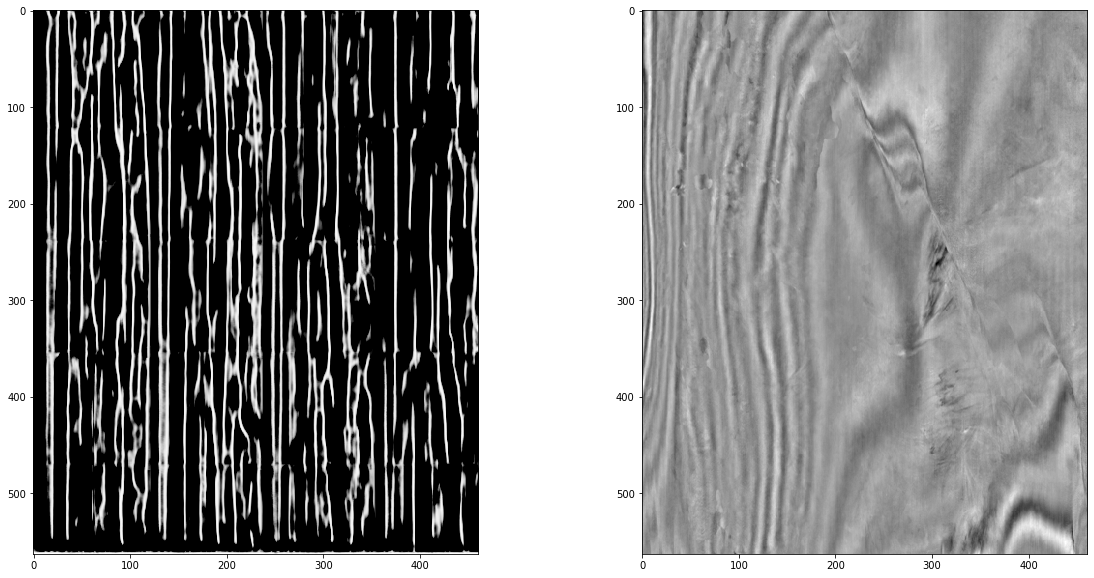

In [0]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(gy[99, :, :], interpolation="bilinear", vmin=0.4, vmax=1.0, cmap=plt.cm.gray)
plt.subplot(1, 2, 2)
plt.imshow(data[99, :, :], cmap="gray")

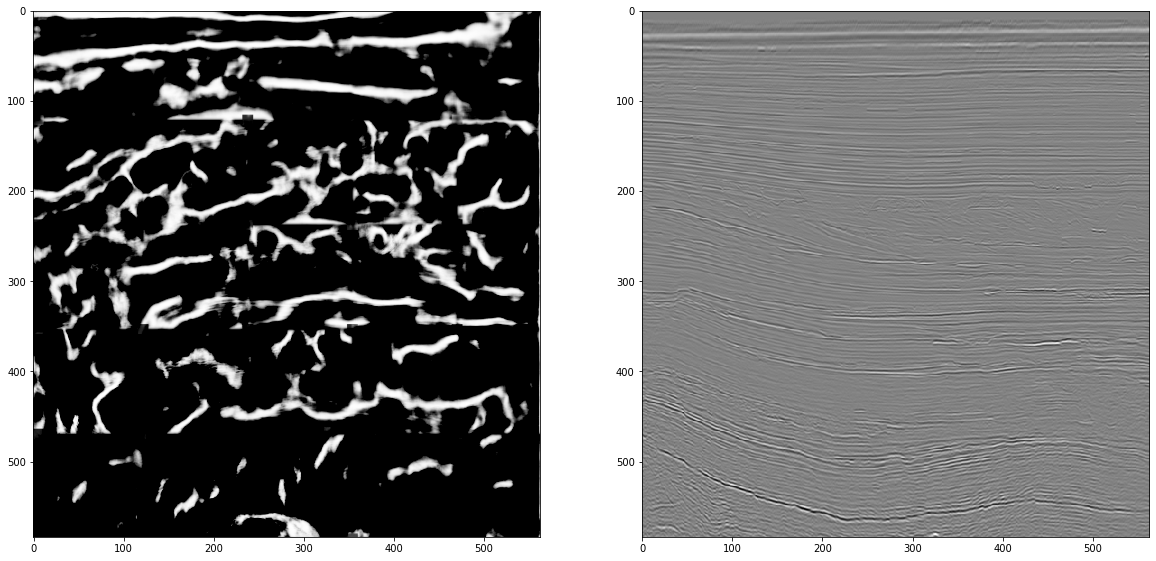

In [0]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(gy[:, :, 99], interpolation="bilinear", vmin=0.4, vmax=1.0, cmap=plt.cm.gray)
plt.subplot(1, 2, 2)
plt.imshow(data[:, :, 99], cmap="gray")

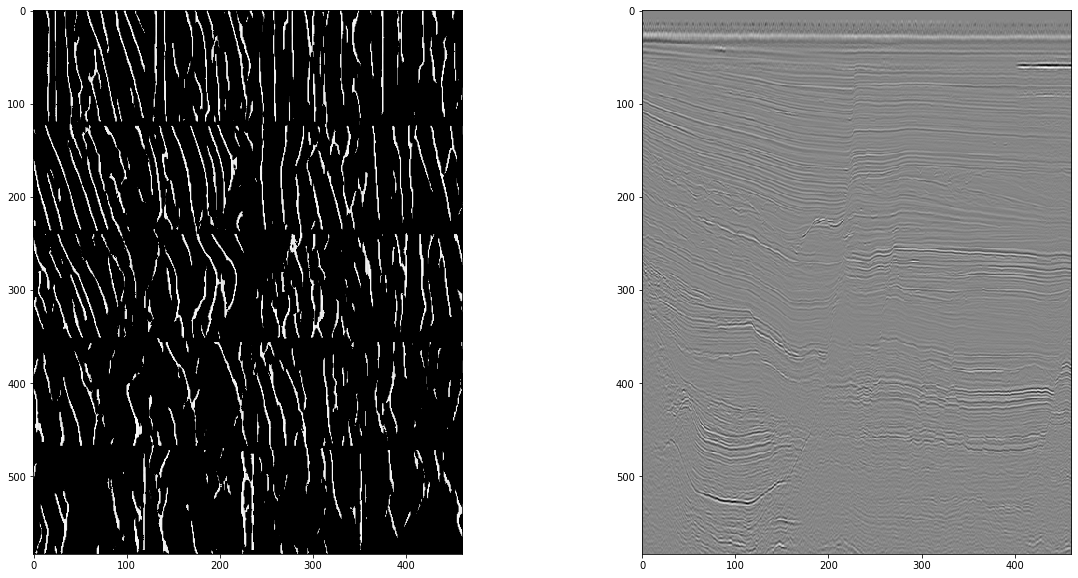

In [0]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)

temp = gy[:, 99, :].copy()
temp[(temp >= 0.1) & (temp <= 0.9)] = 0.
plt.imshow(temp, interpolation="bilinear", vmin=0.4, vmax=1.0, cmap=plt.cm.gray)
plt.subplot(1, 2, 2)
plt.imshow(data[:, 99, :], cmap="gray")

In [0]:
# plt.hist(temp.flatten(), bins=100)

# temp = gy[:, 99, :]
# temp[(temp >= 0.1) & (temp <= 0.9)]


array([], dtype=float32)

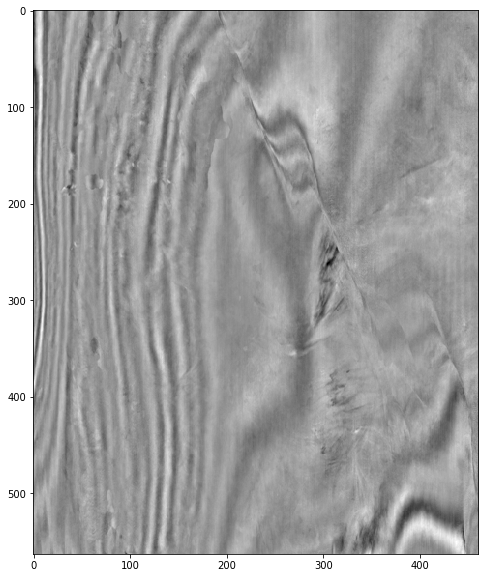

In [0]:
plt.figure(figsize=(10,10))
plt.imshow(data[99, :, :], cmap="gray")

In [0]:
SIZE = 128

In [0]:
predicted = gy[SIZE:3*SIZE, SIZE:3*SIZE, SIZE:3*SIZE]
orig = gp[SIZE:3*SIZE, SIZE:3*SIZE, SIZE:3*SIZE]

In [0]:
layer_id = 77

min_thresh, max_thresh = 0.2, 0.9

temp = predicted[layer_id, :, :].copy()
uncertain = np.zeros_like(temp)
uncertain[(temp >= min_thresh) & (temp <= max_thresh)] = 1.

temp[(temp >= min_thresh) & (temp <= max_thresh)] = 0.

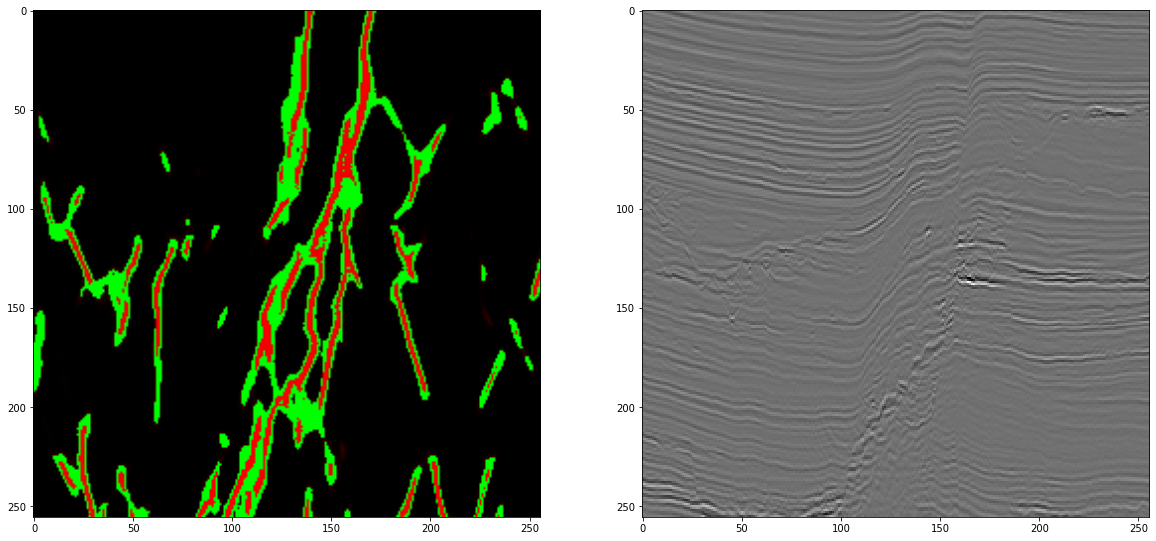

In [0]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(np.dstack([temp, uncertain, np.zeros_like(temp)]), (1, 0, 2)), interpolation="bilinear")#, cmap=plt.cm.gray)
plt.subplot(1, 2, 2)
plt.imshow(orig[layer_id, :, :].T, cmap="gray")

In [0]:
# data = np.transpose(data, (1, 0, 2))
data = data.T

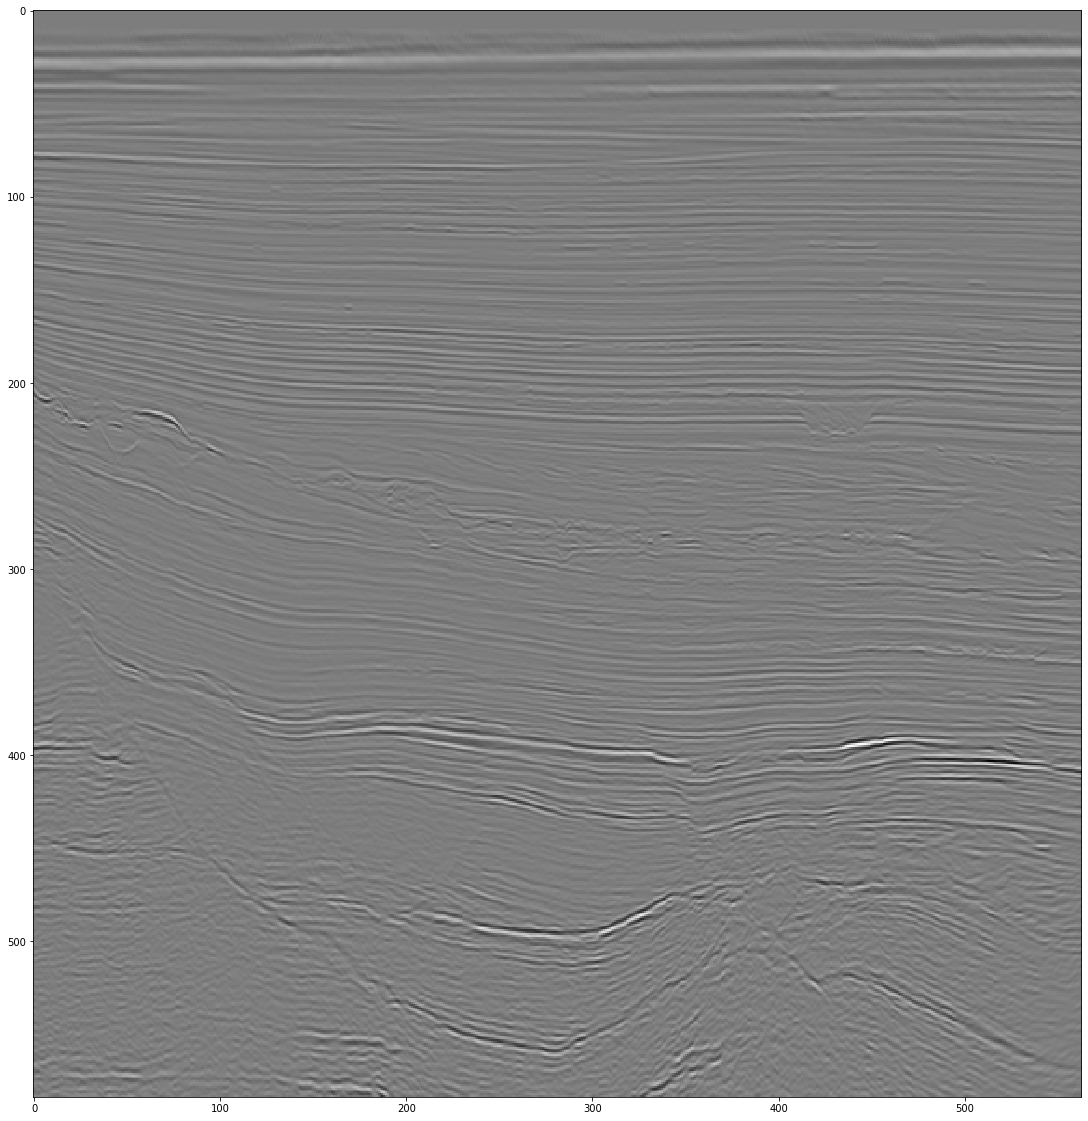

In [0]:
plt.figure(figsize=(20, 20))
plt.imshow(data[:, :, 177], cmap="gray")

In [1]:
data.shape

NameError: ignored

In [27]:
cv2.imwrite("im2.png", data.T[:, :, 177*2])

True

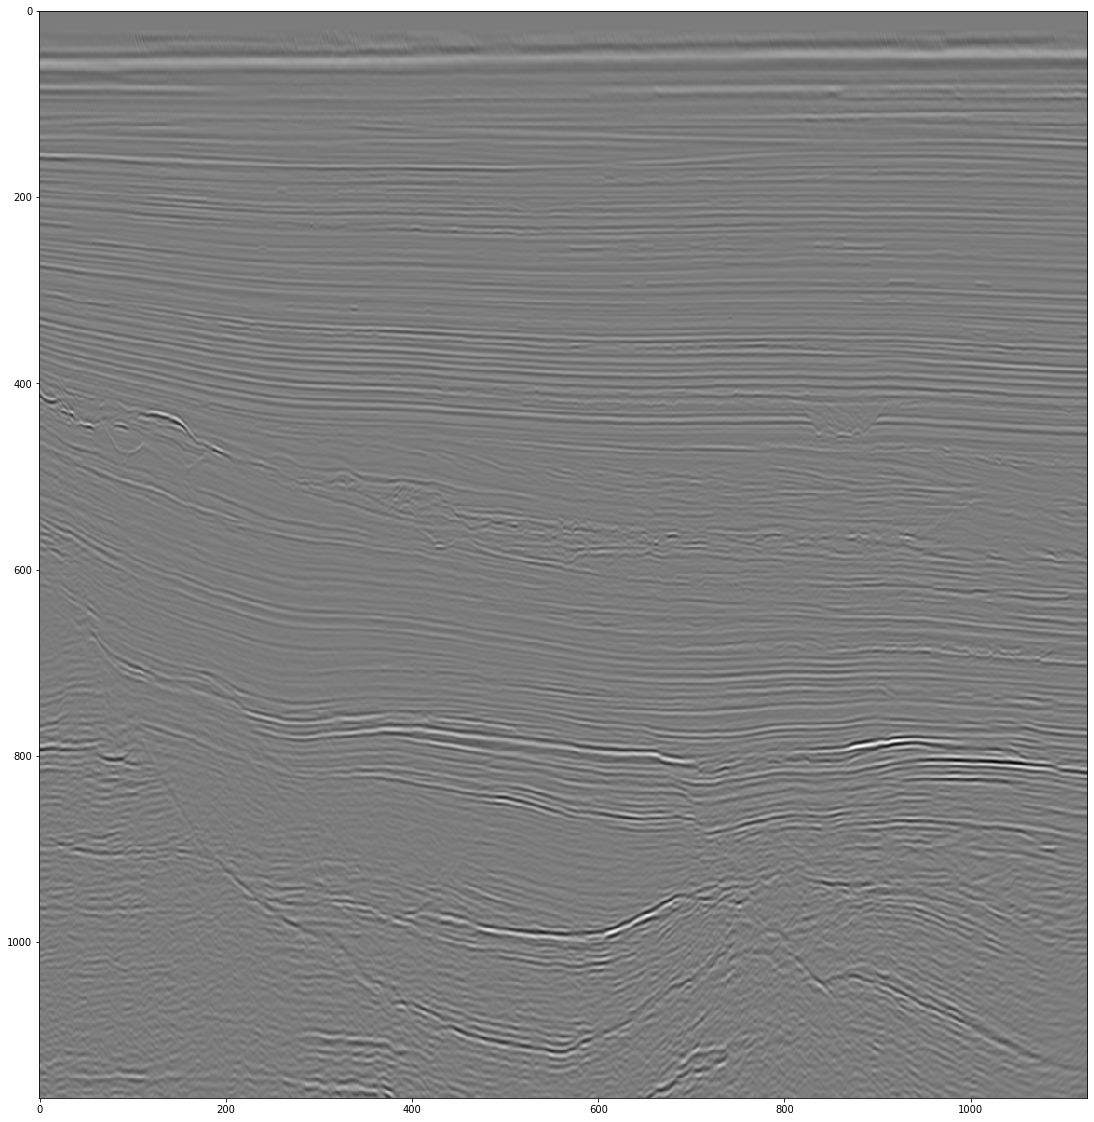

In [26]:
plt.figure(figsize=(20, 20))
plt.imshow(data.T[:, :, 177*2], cmap="gray")